In [2]:
## install additional packages
!pip install optuna seaborn

## download and unzip train/test datasets
!mkdir data
%cd data
!wget https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm/download -O train.tar.gz 
!tar xzf train.tar.gz
!wget https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE/download -O test.tar.gz 
!tar xzf test.tar.gz
%cd ..

## download precomputed vocab
!wget https://raw.githubusercontent.com/shahrukhx01/ocr-test/main/application_vocab_5521.pkl

/Users/shahrukh/Desktop/ml-cybersecurity/assignment3/shahrukh/data
--2021-12-02 19:09:54--  https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm/download
Resolving nextcloud.mpi-klsb.mpg.de (nextcloud.mpi-klsb.mpg.de)... 139.19.205.150
Connecting to nextcloud.mpi-klsb.mpg.de (nextcloud.mpi-klsb.mpg.de)|139.19.205.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134409420 (128M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 128.18M  6.72MB/s    in 21s     

2021-12-02 19:10:14 (6.23 MB/s) - ‘train.tar.gz’ saved [134409420/134409420]

--2021-12-02 19:10:33--  https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE/download
Resolving nextcloud.mpi-klsb.mpg.de (nextcloud.mpi-klsb.mpg.de)... 139.19.205.150
Connecting to nextcloud.mpi-klsb.mpg.de (nextcloud.mpi-klsb.mpg.de)|139.19.205.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96255569 (92M) [application/x-gzip]
Sav

# ML in Cybersecurity: Task 3

## Team
  * **Team name**:  *R2D2C3P0BB8*
  * **Members**:  <br/> **Navdeeppal Singh (s8nlsing@stud.uni-saarland.de)** <br/> **Shahrukh Khan (shkh00001@stud.uni-saarland.de)** <br/> **Mahnoor Shahid (mash00001@stud.uni-saarland.de)**


## Logistics
  * **Due date**: 9th December 2021, 23:59:59
  * Email the completed notebook to: `mlcysec_ws2022_staff@lists.cispa.saarland`
  * Complete this in **teams of 3**
  * Feel free to use the forum to discuss.
  
## Timeline
  * 26-Nov-2021: hand-out
  * **09-Dec-2021**: Email completed notebook
  
  
## About this Project
In this project, you will explore an application of ML to a popular task in cybersecurity: malware classification.
You will be presented with precomputed behaviour analysis reports of thousands of program binaries, many of which are malwares.
Your goal is to train a malware detector using this behavioural reports.


## A Note on Grading
The grading for this project will depend on:
 1. Vectorizing Inputs
   * Obtaining a reasonable vectorized representations of the input data (a file containing a sequence of system calls)
   * Understanding the influence these representations have on your model
 1. Classification Model  
   * Following a clear ML pipeline
   * Obtaining reasonable performances (>60\%) on held-out test set
   * Choice of evaluation metric
   * Visualizing loss/accuracy curves
 1. Analysis
   * Which methods (input representations/ML models) work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
   * Anything else you find interesting (this part is open-ended)


## Grading Details
 * 40 points: Vectorizing input data (each input = behaviour analysis file in our case)
 * 40 points: Training a classification model
 * 15 points: Analysis/Discussion
 * 5 points: Clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your project report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use the final summary to provide a report about these.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.1: Updated deadline
  * v1.0: Initial notebook
  
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 
import pathlib
from pathlib import Path

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [27]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
import pandas as pd
import warnings
import seaborn as sns
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice
from sklearn.metrics import recall_score, plot_confusion_matrix, accuracy_score, classification_report
# Keep it minimal! We should be easily able to reproduce your code.

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Setup

  * Download the datasets: [train](https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm) (128M) and [test](https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE) (92M)
  * Unpack them under `./data/train` and `./data/test`
  * Hint: you can execute shell scripts from notebooks using the `!` prefix, e.g., `! wget <url>`

In [3]:
# Check that you are prepared with the data
try:
    print(f"# train examples (Should be 13682) : ", len(os.listdir('./data/train')))
    print(f"# test examples (Should be 10000) : ", len(os.listdir('./data/test')))

except Exception as e:
    print("You don't have the data!")

# train examples (Should be 13682) :  13682
# test examples (Should be 10000) :  10000


Now that you're set, let's briefly look at the data you have been handed.
Each file encodes the behavior report of a program (potentially a malware), using an encoding scheme called "The Malware Instruction Set" (MIST for short).
At this point, we highly recommend you briefly read-up Sec. 2 of the [MIST](http://www.mlsec.org/malheur/docs/mist-tr.pdf) documentation.

You will find each file named as `filename.<malwarename>`:
```
» ls data/train | head
00005ecc06ae3e489042e979717bb1455f17ac9d.NothingFound
0008e3d188483aeae0de62d8d3a1479bd63ed8c9.Basun
000d2eea77ee037b7ef99586eb2f1433991baca9.Patched
000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
0010f78d3ffee61101068a0722e09a98959a5f2c.Basun
0013cd0a8febd88bfc4333e20486bd1a9816fcbf.Basun
0014aca72eb88a7f20fce5a4e000c1f7fff4958a.Texel
001ffc75f24a0ae63a7033a01b8152ba371f6154.Texel
0022d6ba67d556b931e3ab26abcd7490393703c4.Basun
0028c307a125cf0fdc97d7a1ffce118c6e560a70.Swizzor
...
```
and within each file, you will see a sequence of individual systems calls monitored duing the run-time of the binary - a malware named 'Basun' in the case:
```
» head data/train/000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
# process 000006c8 0000066a 022c82f4 00000000 thread 0001 #
02 01 | 000006c8 0000066a 00015000
02 02 | 00006b2c 047c8042 000b9000
02 02 | 00006b2c 047c8042 00108000
02 02 | 00006b2c 047c8042 00153000
02 02 | 00006b2c 047c8042 00091000
02 02 | 00006b2c 047c8042 00049000
02 02 | 00006b2c 047c8042 000aa000
02 02 | 00006b2c 047c8042 00092000
02 02 | 00006b2c 047c8042 00011000
...
```
(**Note**: Please ignore the first line that begins with `# process ...`.)

Your task in this project is to train a malware detector, which given the sequence of system calls (in the MIST-formatted file like above), predicts one of 10 classes: `{ Agent, Allaple, AutoIt, Basun, NothingFound, Patched, Swizzor, Texel, VB, Virut }`, where `NothingFound` roughly represents no malware is present.
In terms of machine learning terminology, your malware detector $F: X \rightarrow Y$ should learn a mapping from the MIST-encoded behaviour report (the input $x \in X$) to the malware class $y \in Y$.

Consequently, you will primarily tackle two challenges in this project:
  1. "Vectorizing" the input data i.e., representing each input (file) as a tensor
  1. Training an ML model
  

### Some tips:
  * Begin with an extremely simple representation/ML model and get above chance-level classification performance
  * Choose your evaluation metric wisely
  * Save intermediate computations (e.g., a token to index mapping). This will avoid you parsing the entire dataset for every experiment
  * Try using `multiprocessing.Pool` to parallelize your `for` loops

---

# 1. Vectorize Data

## 1.a. Load Raw Data
## => We converted list of list lines to string to save memory in order to load entire dataset

In [4]:
train_path = './data/train'
test_path = './data/test'
n_workers = 10
project_mode = 'trainval'    # trainval, traintest, debug, eval
np.random.seed(123) 

In [5]:
def load_content(filepath):
    '''Given a filepath, returns (content, classname), where content = [list of lines in file]'''
    ## load file content
    file = open(filepath, "r")
    file_lines = file.read()
    ## here converted list of list lines to string to save memory in order to load entire dataset
    lines = "\n".join(file_lines.splitlines())
    file.close()

    ## extracting label
    label = filepath.split(".")[-1]
    return lines, label


def load_data(data_path, nworkers=10):
    '''Returns each data sample as a tuple (x, y), x = sequence of strings (i.e., syscalls), y = malware program class'''
    raw_data_samples = []
    
    file_paths = [f"{data_path}/{filename}" for filename in os.listdir(data_path)]
    pool = Pool(processes=nworkers)
 
    raw_data_samples = pool.map(load_content, file_paths)
    return raw_data_samples

def pickle_file(out_path, file_content):
    with open(out_path, 'wb') as wf:
        pickle.dump(file_content, wf)
        
def unpickle_file(in_path):
    return pickle.load(open(in_path, "rb"))

# Note on data splits:
We perform the split 80%/20% the train set, to divide it to train and validation set when `project_mode` is `trainval`,
however, we store the validation set in `test_raw_samples` for consistency purposes.

In [14]:
## in trainval mode we use test_raw_samples variable to hold validation dataset
train_raw_samples, test_raw_samples = [], []
 
if project_mode == 'trainval':
    print('=> Loading training data ... ')
    train_raw_samples = load_data(Path(train_path), nworkers=n_workers)
    # To perform the same split across multiple runs
    np.random.seed(123)          
    # Split data into train and validation set
    np.random.shuffle(train_raw_samples)
    train_raw_samples, test_raw_samples = train_raw_samples[:int(len(train_raw_samples)*0.8)], train_raw_samples[int(len(train_raw_samples)*0.8):]

elif project_mode == 'traintest':
    ## loading train and test set
    print('=> Loading training data ... ')
    train_raw_samples = load_data(Path(train_path), nworkers=n_workers)
    print('=> Loading testing data ... ')
    test_raw_samples = load_data(Path(test_path), nworkers=n_workers)
    
elif project_mode == 'debug':
    # Optional, use a small subset of the training and validation data for fast debugging
    print('=> Loading training data ... ')
    train_raw_samples = load_data(Path(train_path), nworkers=n_workers)[:100]
    print('=> Loading testing data ... ')
    test_raw_samples = load_data(Path(test_path), nworkers=n_workers)[:100]

else:
    raise ValueError('Unrecognized mode')

if project_mode == 'trainval':
    print('=> # Train samples = ', len(train_raw_samples))
    print('=> # Validation  samples = ', len(test_raw_samples))
else:
    print('=> # Train samples = ', len(train_raw_samples))
    print('=> # Test  samples = ', len(test_raw_samples))
    

=> Loading training data ... 
=> Loading testing data ... 
=> # Train samples =  13682
=> # Test  samples =  10000


## 1.b. Vectorize: Setup

Make one pass over the inputs to identify relevant features/tokens.

Suggestion:
  - identify tokens (e.g., unigrams, bigrams)
  - create a token -> index (int) mapping. Note that you might have a >10K unique tokens. So, you will have to choose a suitable "vocabulary" size.

In [15]:
# Feel free to edit anything in this block

def get_key_idx_map(counter, vocab_size, ukn_token='_ukn_'):
    """counter is a mapping: token -> count
    build vectorizer using vocab_size most common elements"""
    key_to_idx, idx_to_key = dict(), dict()
    
    for idx, (key, value) in tqdm(enumerate(list(train_counter.items())[:vocab_size-1])):
        ## perform mapping for token
        key_to_idx[key] = idx
        idx_to_key[idx] = key
    ## perform mapping for unk token at the end
    key_to_idx[ukn_token] = vocab_size - 1
    idx_to_key[vocab_size - 1] = ukn_token
    
    return key_to_idx, idx_to_key

def preprocess(data):
    """concatenating all sys calls to single string for tokenization
    removing extraneous information such as lines with '# process', white spaces and '|' characters"""
    for i, (X,y) in enumerate(tqdm(data)):
        example = ""
        for line in X.split("\n"):
            ## skip lines containing '# process'
            if "# process" in line:
                continue
            ## remove extraneous white spaces and 
            example += line.replace("|","").replace("  ", " ").strip() + " "
        example = example.strip()
        ## assign preprocessed sample
        data[i] = (example, y)
    return data
        
def count_words(data):
    """
    count token occurences for building vocabulary later
    """
    counter = {}
    for X,y in tqdm(data):
        counts = dict(Counter(X.split()))
        counter = dict(counter, **counts)
    return counter

In [16]:
"""
Preprocessing both train and test set and
Creating token counter for building vocabulary on train set
"""
train_raw_samples = preprocess(train_raw_samples)
train_counter = count_words(train_raw_samples)
test_raw_samples = preprocess(test_raw_samples)

In [17]:
## Code for finding appropriate threshold for setting `MAX_VOCAB_SIZE`
def choose_vocab_size(min_frequency_threshold=10):
    count = 0
    for value,key in sorted([(value,key) for (key,value) in train_counter.items()], reverse=True):
        if value > min_frequency_threshold:
            count+=1
    print(f"Number of tokens are {count} for min. frequency threshold={min_frequency_threshold}")
#choose_vocab_size(10)

In [19]:
## sorting the counters wrt to count values in decending order
train_counter = {key:value for value, key in  sorted([(value,key) for (key,value) in train_counter.items()], reverse=True)}

In [6]:
# Feel free to edit anything in this block
## By keeping a minimum count threshold of 10 we get 5520 most frequent tokens in train dataset
## adding one to MAX_VOCAB_SIZE for _ukn_ token
MAX_VOCAB_SIZE = 5520 + 1
token_to_idx, idx_to_token = {}, {}
# Path for vocab for saving and loading
vocab_path = 'application_vocab_{}.pkl'.format(MAX_VOCAB_SIZE)

## check if vocab already exists on file system otherwise create one
if os.path.isfile(vocab_path):
    token_to_idx, idx_to_token = unpickle_file(vocab_path)['token_to_idx'], unpickle_file(vocab_path)['idx_to_token']
    
else:
    token_to_idx, idx_to_token = get_key_idx_map(train_counter, MAX_VOCAB_SIZE)
    with open(vocab_path, 'wb') as wf:
        dct = {'token_to_idx': token_to_idx,
              'idx_to_token': idx_to_token}
        pickle.dump(dct, wf)

## 1.c. Vectorize Data

Use the (token $\rightarrow$ index) mapping you created before to vectorize your data

In [7]:
def sample_to_idx(sample):
    """
    Maps each document's tokens to their ids in the vocabulary
    """
    idx_sample = []
    for token in sample.split(' '):
        if token not in token_to_idx:
                token = '_ukn_'
        idx_sample.append(token_to_idx[token])
    return idx_sample


## define mapping for labels
label_encodings = {'Virut': 0,
 'Swizzor': 1,
 'Agent': 2,
 'Patched': 3,
 'Allaple': 4,
 'Texel': 5,
 'Basun': 6,
 'AutoIt': 7,
 'NothingFound': 8,
 'VB': 9}

In [43]:
def vectorize_raw_samples_bow(raw_samples, vocab_length, nworkers=10):
    """
    BAG-OF-WORDS Vectorizer which vectorizes examples by adding '1' for
    term i occuring in document j, hence producing a vector for each document
    raw_samples: List of documents to vectorize
    vocab_length: Size of the vocabulary
    """
    vectorized_samples = []
    labels = []
    lengths = []
    try:
        for idx, (X,y) in tqdm(enumerate(raw_samples)):
            vectorized_sample = []
            ## map labeks to ids
            label = label_encodings[y]
            ## map tokens to ids
            X_idx = sample_to_idx(X)

            ## initializing placeholder vector with unknown tokens equivalent to max_length
            vector_sample = [0] * vocab_length

            ## creating Bag of Words Vectors 
            for index, val in enumerate(set(X_idx)):
                vector_sample[val] = 1
            sequence_length = len(X_idx)

            ## append sample to respective lists
            vectorized_samples.append(vector_sample)
            labels.append(label)
            lengths.append(sequence_length)
    except:
        pass
            
    return (torch.DoubleTensor(vectorized_samples), torch.LongTensor(labels), torch.LongTensor(lengths))



def vectorize_raw_samples_count_vectorizer(raw_samples, vocab_length, nworkers=10):
    """ 
    Count Vectorizer is similar to BAG-OF-WORDS Vectorizer, however this vectorizer places 'counts/frequency' for
    term i occuring in document j, hence producing a vector for each document
    raw_samples: List of documents to vectorize
    vocab_length: Size of the vocabulary
    """
    vectorized_samples = []
    labels = []
    lengths = []
    try:
        for idx, (X,y) in tqdm(enumerate(raw_samples)):
            vectorized_sample = []
            ## map labeks to ids
            label = label_encodings[y]
            ## map tokens to ids
            X_idx = sample_to_idx(X)

            ## initializing placeholder vector with unknown tokens equivalent to max_length
            vector_sample = [0] * vocab_length
            ## compute counts
            counts = dict(Counter(X_idx))
            ## creating Count Vectors 
            for index, (key, val) in enumerate(counts.items()):
                vector_sample[key] = val
            sequence_length = len(X_idx)

            ## append sample to respective lists
            vectorized_samples.append(vector_sample)
            labels.append(label)
            lengths.append(sequence_length)
    except:
        pass
    
    return (torch.DoubleTensor(vectorized_samples), torch.LongTensor(labels), torch.LongTensor(lengths))



def vectorize_raw_samples_tfidf(raw_samples, vocab_length, nworkers=10):
    """ 
    TF-IDF Vectorizer vectorizes examples computing term frequencies and inverse document
    for freqyencies for term i occuring in document j, hence producing a vector for each document
    raw_samples: List of documents to vectorize
    vocab_length: Size of the vocabulary
    """
    labels = []
    lengths = []
    tf_samples = [] ## term frequency vector for each sample
    tf_idf = np.zeros(shape=(len(raw_samples), vocab_length))
    try:
        for idx, (X,y) in tqdm(enumerate(raw_samples)):
            vectorized_sample = []
            ## map labeks to ids
            label = label_encodings[y]
            ## map tokens to ids
            X_idx = sample_to_idx(X)

            ## initializing placeholder vector with unknown tokens equivalent to max_length
            vector_sample = [0] * vocab_length
            ## compute counts
            counts = dict(Counter(X_idx))
            ## creating Count Vectors 
            for index, (key, val) in enumerate(counts.items()):
                vector_sample[key] = val
            sequence_length = len(X_idx)
            ## compute term frequencies 'tf => # of times term in the doc / total words in the doc'
            term_frequencies = np.array(vector_sample) / sequence_length
            ## append sample to respective lists
            labels.append(label)
            lengths.append(sequence_length)
            tf_samples.append(term_frequencies)

        # compute idf
        # 1. computing BOW matrix 
        bow = np.zeros(shape=(len(raw_samples), vocab_length))
        for i in range(len(tf_samples)):
            for j in range(vocab_length):
                if tf_samples[i][j] > 0:
                    bow[i,j] = 1
        # 2, compute idf scores 'idf(t) => log( ((1 + # of docs)/ # of docs with term t + 1) + 1 ) '
        idf = [np.log(((1+len(raw_samples))/(1+sum(bow[:, i])))+1) for i in range(vocab_length)]

        # compute tf-idf => tf * idf
        tf = np.array(tf_samples)

        for i in range(vocab_length):
            tf_idf[:, i] = tf[:, i] * idf[i]
    except:
        pass
    
    return (torch.DoubleTensor(tf_idf), torch.LongTensor(labels), torch.LongTensor(lengths))

In [8]:
## select vectorization_method from {'BOW','COUNT_VEC', 'TF_IDF'}
vectorization_method = "BOW" 
train_data, test_data = None, None
load_pre_computed_vectors = True  ##load vector pickles files from disk if set True

def perform_vectorization():
    """
    Performs vectorization based on the chosen technique 
    applies the method to convert documents to vectors
    """
    if vectorization_method == "BOW":
        print(f'=> {vectorization_method} Processing: Train')
        train_data = vectorize_raw_samples_bow(train_raw_samples, vocab_length=MAX_VOCAB_SIZE)
        print()
        print(f'=> {vectorization_method} Processing: Test')
        test_data = vectorize_raw_samples_bow(test_raw_samples, vocab_length=MAX_VOCAB_SIZE)

    elif vectorization_method == "COUNT_VEC":
        print(f'=> {vectorization_method} Processing: Train')
        train_data = vectorize_raw_samples_count_vectorizer(train_raw_samples, vocab_length=MAX_VOCAB_SIZE)
        print()
        print(f'=> {vectorization_method} Processing: Test')
        test_data = vectorize_raw_samples_count_vectorizer(test_raw_samples, vocab_length=MAX_VOCAB_SIZE)

    elif vectorization_method == "TF_IDF":
        print(f'=> {vectorization_method} Processing: Train')
        train_data = vectorize_raw_samples_tfidf(train_raw_samples, vocab_length=MAX_VOCAB_SIZE)
        print()
        print(f'=> {vectorization_method} Processing: Test')
        test_data = vectorize_raw_samples_tfidf(test_raw_samples, vocab_length=MAX_VOCAB_SIZE)
    else:
        print("Please choose one of the following vectorization method: {'BOW','COUNT_VEC', 'TF_IDF'}")
        

In [9]:
if load_pre_computed_vectors:
    if project_mode == 'trainval':
        train_data = unpickle_file(f'train_v5521_{vectorization_method}.pkl')  
        test_data = unpickle_file(f'val_v5521_{vectorization_method}.pkl')
    elif project_mode == 'traintest':
        train_data = unpickle_file(f'train_v5521_{vectorization_method}.pkl')  
        test_data = unpickle_file(f'test_v5521_{vectorization_method}.pkl')    
    else:
        print("Please choose one of the following project modes: {'trainval','traintest', 'eval'}")
else:
    perform_vectorization()    

In [10]:

# Suggestions: 
#
# (a) You can use torch.utils.data.TensorDataset to represent the tensors you created previously
# trainset = TensorDataset(train_x, train_y)
# testset = TensorDataset(test_x, test_y)
#
# (b) Store your datasets to disk so that you do not need to precompute it every time

"""
Standard Pytorch Dataset class for loading datasets.
"""
class MalwareDataset(Dataset):

    def __init__(self, data_tensor, target_tensor, length_tensor):
        """
        initializes  and populates the the length, data and target tensors, and raw texts list
        """
        assert data_tensor.size(0) == target_tensor.size(0) == length_tensor.size(0)
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
        self.length_tensor = length_tensor

    def __getitem__(self, index):
        """
        returns the tuple of data tensor, targets, lengths of sequences tensor
        """
        return self.data_tensor[index], self.target_tensor[index], self.length_tensor[index]

    def __len__(self):
        """
        returns the length of the data tensor.
        """
        return self.data_tensor.size(0)

## instantiate train and test datasets
malware_testset = MalwareDataset(test_data[0], test_data[1], test_data[2])
malware_trainset = MalwareDataset(train_data[0], train_data[1], train_data[2])

# 2. Train Model

You will now train an ML model on the vectorized datasets you created previously.

_Note_: Although we often refer to each input as a 'vector' for simplicity, each of your inputs can also be higher dimensional tensors.

## 2.a. Helpers

In [11]:
# Feel free to edit anything in this block

def evaluate_preds(y_gt, y_pred):
    recall = recall_score(y_gt, y_pred, average='micro')
    return recall

def load_model(model, out_path):
    model.load_state_dict(torch.load(out_path, map_location=set_device))  

def save_model(model, out_path):
    torch.save(model.state_dict(), out_path)

## 2.b. Define Model

Describe your model here.

In [12]:
# Feel free to edit anything in this block

class MalwareNet(nn.Module):
    """
    This class is created to specify the Neural Network on which vectorized datasets we have created previously
    is trained on, validated and later tested.
    It consist of one input layer, one output layer and multiple hidden layers.
    ...
    """
    def __init__(self, input_dim, output_dim, dropout=0.5):
        super(MalwareNet, self).__init__()
        # Layer definitions
        self.layers = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # Forward pass
        return self.layers(x)
            

In [13]:
def _network_training(model, hyper_paramaters, criterion, optimizer, set_device, tuning=False):
    '''
    training the network given the hyperparameters, crtierion and optimizer
    '''
    best_accuracy = 0
    train_loss_history, recall_train_history= list(), list()
    validation_loss_history, recall_validation_history = list(), list()

    for epoch in range(0, hyper_paramaters['NUM_EPOCHS']):
        model.train()
        train_loss_scores = []
        training_acc_scores = []
        y_pred, y_true= list(), list()

        for batch, targets, lengths in trainloader:
            
            ## perform forward pass  
            batch = batch.type(torch.FloatTensor).to(set_device)
            pred = model(batch) 
            preds = torch.max(pred, 1)[1]

            ## accumulate predictions per batch for the epoch
            y_pred += list([x.item() for x in preds.detach().cpu().numpy()])
            targets = torch.LongTensor([x.item() for x in list(targets)])
            y_true +=  list([x.item() for x in targets.detach().cpu().numpy()])
            
            ## compute loss and perform backward pass
            loss = criterion(pred.to(set_device), targets.to(set_device)) ## compute loss 
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

            ## accumulate train loss
            train_loss_scores.append(loss.item())
        
        ## accumulate loss, recall, f1, precision per epoch
        train_loss_history.append((sum(train_loss_scores)/len(train_loss_scores)))
        recall = evaluate_preds(y_true, y_pred)
        recall_train_history.append(recall)
        print(f'Training =>  Epoch : {epoch+1} | Loss : {train_loss_history[-1]} | Recall score: {recall_train_history[-1]}')
       
        model.eval()
        with torch.no_grad():
            validation_loss_scores = list()
            y_true_val, y_pred_val= list(), list()

            ## perform validation pass
            for batch, targets, lengths in testloader:
                ## perform forward pass  
                batch = batch.type(torch.FloatTensor).to(set_device)
                pred = model(batch) 
                preds = torch.max(pred, 1)[1]

                ## accumulate predictions per batch for the epoch
                y_pred_val += list([x.item() for x in preds.detach().cpu().numpy()])
                targets = torch.LongTensor([x.item() for x in list(targets)])
                y_true_val +=  list([x.item() for x in targets.detach().cpu().numpy()])
                
                ## computing validate loss
                loss = criterion(pred.to(set_device), targets.to(set_device)) ## compute loss 

                ## accumulate validate loss
                validation_loss_scores.append(loss.item())
            
            ## accumulate loss, recall, f1, precision per epoch
            validation_loss_history.append((sum(validation_loss_scores)/len(validation_loss_scores)))
            recall = evaluate_preds(y_true_val, y_pred_val)
            recall_validation_history.append(recall)

            print(f'Validation =>  Epoch : {epoch+1} | Loss : {validation_loss_history[-1]} | Recall score: {recall_validation_history[-1]} ')
            
            if not tuning: 
                if recall_validation_history[-1]>best_accuracy:
                    best_accuracy = recall_validation_history[-1]
                    print('Saving the model...')
                    save_model(model, out_path=f"{vectorization_method}_model.ckpt")
                    
            
    if tuning:
        return recall_validation_history
        
    
    return train_loss_history, recall_train_history, validation_loss_history, recall_validation_history

        

## 2.c. Set Hyperparameters

In [ ]:
# Data Loaders
trainloader = DataLoader(malware_trainset, batch_size=64, shuffle=True)
testloader = DataLoader(malware_testset, batch_size=64, shuffle=False)

# Define your hyperparameters here
def _hyper_parameter_tuning(trial):
    
    set_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    hyper_paramaters = {
        'TRAIN_BATCH_SIZE' :  trial.suggest_categorical('TRAIN_BATCH_SIZE', (32, 64)),
        'LEARNING_RATE' : trial.suggest_loguniform('LEARNING_RATE', 0.001, 0.01),
        'OPTIMIZER': trial.suggest_categorical("OPTIMIZER", ["Adam", "RMSprop", "SGD"]),
        'NUM_EPOCHS' : trial.suggest_categorical("NUM_EPOCHS", [3, 5]),
        'DROPOUT' : trial.suggest_categorical("DROPOUT", [0.1, 0.3, 0.5])
    }
    
    model = MalwareNet(input_dim=train_data[0][0].shape[0], output_dim=len(label_encodings)).to(set_device)
    criterion = nn.CrossEntropyLoss().to(set_device)
    optimizer = getattr(optim, hyper_paramaters['OPTIMIZER'])(model.parameters(), lr=hyper_paramaters['LEARNING_RATE'])
    
    recall = _network_training(model, hyper_paramaters, criterion, optimizer, set_device, tuning=True)
    return np.max(recall)

with warnings.catch_warnings(record=True):
    analysis_study = optuna.create_study(direction='maximize')
    analysis_study.optimize(_hyper_parameter_tuning, n_trials=10)

[I 2021-12-03 18:24:40,929] A new study created in memory with name: no-name-c63ef8f2-3cfe-4598-89c1-ac20377d6b0c


Training =>  Epoch : 1 | Loss : 1.1000308754832246 | Recall score: 0.6229328460484239
Validation =>  Epoch : 1 | Loss : 0.6988055608993353 | Recall score: 0.7778589696748265 
Training =>  Epoch : 2 | Loss : 0.757027612262687 | Recall score: 0.7548652352672454
Validation =>  Epoch : 2 | Loss : 0.634306073881859 | Recall score: 0.7815126050420168 
Training =>  Epoch : 3 | Loss : 0.7072913878878881 | Recall score: 0.7735952489721334
Validation =>  Epoch : 3 | Loss : 0.6608426945154057 | Recall score: 0.773109243697479 
Training =>  Epoch : 4 | Loss : 0.7297432046643523 | Recall score: 0.7794426678848789
Validation =>  Epoch : 4 | Loss : 0.6190982821375824 | Recall score: 0.7880891487029594 
Training =>  Epoch : 5 | Loss : 0.6727094672793565 | Recall score: 0.786203746002741


[I 2021-12-03 18:25:04,026] Trial 0 finished with value: 0.7924735111435879 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0031772254309900072, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 5, 'DROPOUT': 0.5}. Best is trial 0 with value: 0.7924735111435879.


Validation =>  Epoch : 5 | Loss : 0.6199188170044921 | Recall score: 0.7924735111435879 
Training =>  Epoch : 1 | Loss : 1.340762806839721 | Recall score: 0.5659205116491549
Validation =>  Epoch : 1 | Loss : 0.9056086554083713 | Recall score: 0.6887102667153818 
Training =>  Epoch : 2 | Loss : 1.3719569503567939 | Recall score: 0.5785290086797624
Validation =>  Epoch : 2 | Loss : 0.956783398639324 | Recall score: 0.6832298136645962 
Training =>  Epoch : 3 | Loss : 1.593111372877692 | Recall score: 0.5058017359524897
Validation =>  Epoch : 3 | Loss : 1.1819085728290468 | Recall score: 0.5717939349652905 
Training =>  Epoch : 4 | Loss : 1.599911350150441 | Recall score: 0.48707172224760165
Validation =>  Epoch : 4 | Loss : 1.3279902685520262 | Recall score: 0.5622944830105956 
Training =>  Epoch : 5 | Loss : 1.5396957862255878 | Recall score: 0.473184102329831


[I 2021-12-03 18:25:27,234] Trial 1 finished with value: 0.6887102667153818 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.009860026136663418, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 5, 'DROPOUT': 0.1}. Best is trial 0 with value: 0.7924735111435879.


Validation =>  Epoch : 5 | Loss : 1.245877465536428 | Recall score: 0.5699671172816952 
Training =>  Epoch : 1 | Loss : 1.1130347106345864 | Recall score: 0.629968021927821
Validation =>  Epoch : 1 | Loss : 0.7546563273252442 | Recall score: 0.752648885641213 
Training =>  Epoch : 2 | Loss : 0.7582075332486088 | Recall score: 0.7539515760621288
Validation =>  Epoch : 2 | Loss : 0.6403105092603106 | Recall score: 0.7800511508951407 
Training =>  Epoch : 3 | Loss : 0.7438955574058169 | Recall score: 0.7732297852900868


[I 2021-12-03 18:25:41,344] Trial 2 finished with value: 0.7873584216295214 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.0036830483085327007, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3, 'DROPOUT': 0.5}. Best is trial 0 with value: 0.7924735111435879.


Validation =>  Epoch : 3 | Loss : 0.6229036914747815 | Recall score: 0.7873584216295214 
Training =>  Epoch : 1 | Loss : 1.0881398450150046 | Recall score: 0.6214709913202375
Validation =>  Epoch : 1 | Loss : 0.658339340326398 | Recall score: 0.773109243697479 
Training =>  Epoch : 2 | Loss : 0.7159273793438969 | Recall score: 0.7636363636363637
Validation =>  Epoch : 2 | Loss : 0.6370741641798685 | Recall score: 0.7888198757763976 
Training =>  Epoch : 3 | Loss : 0.6877163257016692 | Recall score: 0.7814527181361353
Validation =>  Epoch : 3 | Loss : 0.6022555044917173 | Recall score: 0.7873584216295214 
Training =>  Epoch : 4 | Loss : 0.6711319594449082 | Recall score: 0.7762448606669712
Validation =>  Epoch : 4 | Loss : 0.611093049825624 | Recall score: 0.7888198757763976 
Training =>  Epoch : 5 | Loss : 0.6742792302785918 | Recall score: 0.7820009136592051


[I 2021-12-03 18:26:04,450] Trial 3 finished with value: 0.794665692363902 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0027997096218844567, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 5, 'DROPOUT': 0.5}. Best is trial 3 with value: 0.794665692363902.


Validation =>  Epoch : 5 | Loss : 0.5973551980284757 | Recall score: 0.794665692363902 
Training =>  Epoch : 1 | Loss : 1.1155335272467413 | Recall score: 0.6155322064869804
Validation =>  Epoch : 1 | Loss : 0.7723485390807308 | Recall score: 0.7599561563755937 
Training =>  Epoch : 2 | Loss : 0.9586293518023435 | Recall score: 0.7307446322521699
Validation =>  Epoch : 2 | Loss : 0.7087214415849641 | Recall score: 0.7793204238217026 
Training =>  Epoch : 3 | Loss : 0.9621711087434791 | Recall score: 0.7272727272727273
Validation =>  Epoch : 3 | Loss : 0.7176632084125696 | Recall score: 0.7778589696748265 
Training =>  Epoch : 4 | Loss : 1.0297023425346408 | Recall score: 0.7301964367291001
Validation =>  Epoch : 4 | Loss : 0.6956149755522262 | Recall score: 0.7763975155279503 
Training =>  Epoch : 5 | Loss : 0.9561724016486213 | Recall score: 0.7392416628597533


[I 2021-12-03 18:26:27,325] Trial 4 finished with value: 0.7793204238217026 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.005363026429645663, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 5, 'DROPOUT': 0.5}. Best is trial 3 with value: 0.794665692363902.


Validation =>  Epoch : 5 | Loss : 0.6905260307844295 | Recall score: 0.7789550602849835 
Training =>  Epoch : 1 | Loss : 2.2944126295488934 | Recall score: 0.21681132937414344
Validation =>  Epoch : 1 | Loss : 2.284345809803453 | Recall score: 0.2502740226525393 
Training =>  Epoch : 2 | Loss : 2.2757492508999135 | Recall score: 0.2488807674737323
Validation =>  Epoch : 2 | Loss : 2.2659329869026363 | Recall score: 0.2502740226525393 
Training =>  Epoch : 3 | Loss : 2.257688451644986 | Recall score: 0.2488807674737323
Validation =>  Epoch : 3 | Loss : 2.2488337616587795 | Recall score: 0.2502740226525393 
Training =>  Epoch : 4 | Loss : 2.240580371645994 | Recall score: 0.2492462311557789
Validation =>  Epoch : 4 | Loss : 2.2324148388796075 | Recall score: 0.2502740226525393 
Training =>  Epoch : 5 | Loss : 2.223242382670558 | Recall score: 0.2490634993147556


[I 2021-12-03 18:26:40,664] Trial 5 finished with value: 0.2502740226525393 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.0013909155759201078, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 5, 'DROPOUT': 0.5}. Best is trial 3 with value: 0.794665692363902.


Validation =>  Epoch : 5 | Loss : 2.2165011583372602 | Recall score: 0.2502740226525393 
Training =>  Epoch : 1 | Loss : 2.297822406125623 | Recall score: 0.07291000456829602
Validation =>  Epoch : 1 | Loss : 2.2853450276130856 | Recall score: 0.08878333942272561 
Training =>  Epoch : 2 | Loss : 2.2744852831197337 | Recall score: 0.21279122887163088
Validation =>  Epoch : 2 | Loss : 2.26320003908734 | Recall score: 0.24187066130800147 
Training =>  Epoch : 3 | Loss : 2.25255604954653 | Recall score: 0.25207857469164
Validation =>  Epoch : 3 | Loss : 2.2424383662467777 | Recall score: 0.24187066130800147 
Training =>  Epoch : 4 | Loss : 2.2314580318539643 | Recall score: 0.25116491548652353
Validation =>  Epoch : 4 | Loss : 2.222840808158697 | Recall score: 0.24187066130800147 
Training =>  Epoch : 5 | Loss : 2.212048189584599 | Recall score: 0.2535404294198264


[I 2021-12-03 18:26:53,579] Trial 6 finished with value: 0.24187066130800147 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.0015679535585867276, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 5, 'DROPOUT': 0.5}. Best is trial 3 with value: 0.794665692363902.


Validation =>  Epoch : 5 | Loss : 2.2044096991073254 | Recall score: 0.24187066130800147 
Training =>  Epoch : 1 | Loss : 2.319662913333538 | Recall score: 0.050525354042941985
Validation =>  Epoch : 1 | Loss : 2.3075776155604872 | Recall score: 0.03215199123127512 
Training =>  Epoch : 2 | Loss : 2.2955671715181927 | Recall score: 0.08743718592964825
Validation =>  Epoch : 2 | Loss : 2.2848962295887083 | Recall score: 0.09426379247351115 
Training =>  Epoch : 3 | Loss : 2.273710022138995 | Recall score: 0.22311557788944725
Validation =>  Epoch : 3 | Loss : 2.2635302599086318 | Recall score: 0.24187066130800147 
Training =>  Epoch : 4 | Loss : 2.252368748188019 | Recall score: 0.25582457743261766
Validation =>  Epoch : 4 | Loss : 2.2434398296267486 | Recall score: 0.24187066130800147 
Training =>  Epoch : 5 | Loss : 2.2312754655993263 | Recall score: 0.25363179534033803


[I 2021-12-03 18:27:06,505] Trial 7 finished with value: 0.24187066130800147 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.001476773324930558, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 5, 'DROPOUT': 0.5}. Best is trial 3 with value: 0.794665692363902.


Validation =>  Epoch : 5 | Loss : 2.2241597120151964 | Recall score: 0.24187066130800147 
Training =>  Epoch : 1 | Loss : 2.251894724923511 | Recall score: 0.2201005025125628
Validation =>  Epoch : 1 | Loss : 2.2101386314214664 | Recall score: 0.24187066130800147 
Training =>  Epoch : 2 | Loss : 2.171167740988177 | Recall score: 0.25701233439926907
Validation =>  Epoch : 2 | Loss : 2.144756611003432 | Recall score: 0.24187066130800147 
Training =>  Epoch : 3 | Loss : 2.115110772986745 | Recall score: 0.2566468707172225
Validation =>  Epoch : 3 | Loss : 2.0952961999316546 | Recall score: 0.24187066130800147 
Training =>  Epoch : 4 | Loss : 2.0650697516840557 | Recall score: 0.25874828688899043
Validation =>  Epoch : 4 | Loss : 2.0558717139931613 | Recall score: 0.24187066130800147 
Training =>  Epoch : 5 | Loss : 2.0343749980593837 | Recall score: 0.26624029237094565


[I 2021-12-03 18:27:19,286] Trial 8 finished with value: 0.24187066130800147 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.006919868586810927, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 5, 'DROPOUT': 0.1}. Best is trial 3 with value: 0.794665692363902.


Validation =>  Epoch : 5 | Loss : 2.0236197876375774 | Recall score: 0.24187066130800147 
Training =>  Epoch : 1 | Loss : 2.268897827281508 | Recall score: 0.16738236637734125
Validation =>  Epoch : 1 | Loss : 2.238264887831932 | Recall score: 0.24187066130800147 
Training =>  Epoch : 2 | Loss : 2.2051571164020274 | Recall score: 0.25637277295568756
Validation =>  Epoch : 2 | Loss : 2.1818804075551586 | Recall score: 0.24187066130800147 
Training =>  Epoch : 3 | Loss : 2.1549610453982684 | Recall score: 0.25829145728643216


[I 2021-12-03 18:27:27,398] Trial 9 finished with value: 0.24187066130800147 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.00468226023599736, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 3, 'DROPOUT': 0.5}. Best is trial 3 with value: 0.794665692363902.


Validation =>  Epoch : 3 | Loss : 2.1346853278404057 | Recall score: 0.24187066130800147 


### Selection of hyper parameters on the basis of hyperparameter tuning

In [36]:
print("SELECTED BEST SET OF HYPER-PARAMETERS:",analysis_study.best_params)
print("RECALL SCORE ACHEIVED USING THE BEST HYPER-PARAMTERS", analysis_study.best_value)

SELECTED BEST SET OF HYPER-PARAMETERS: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0027997096218844567, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 5, 'DROPOUT': 0.5}
RECALL SCORE ACHEIVED USING THE BEST HYPER-PARAMTERS 0.794665692363902


In [37]:
df = analysis_study.trials_dataframe().drop(['state','datetime_start','datetime_complete','number'], axis=1)
df.index.name = 'trial'
df.sort_values(by='value', ascending=False).head(20)

,value,duration,params_DROPOUT,params_LEARNING_RATE,params_NUM_EPOCHS,params_OPTIMIZER,params_TRAIN_BATCH_SIZE
trial,,,,,,,
3,0.794666,0 days 00:00:23.105603,0.5,0.002800,5,Adam,64
0,0.792474,0 days 00:00:23.096978,0.5,0.003177,5,Adam,64
2,0.787358,0 days 00:00:14.110369,0.5,0.003683,3,Adam,32
4,0.779320,0 days 00:00:22.875442,0.5,0.005363,5,Adam,64
1,0.688710,0 days 00:00:23.207712,0.1,0.009860,5,Adam,64
5,0.250274,0 days 00:00:13.330855,0.5,0.001391,5,SGD,32
6,0.241871,0 days 00:00:12.915385,0.5,0.001568,5,SGD,32
7,0.241871,0 days 00:00:12.926099,0.5,0.001477,5,SGD,32
8,0.241871,0 days 00:00:12.763447,0.1,0.006920,5,SGD,32


#### Hyper-parameters were important and how did they influence your results?
> From the results of the hyper parameter tuning we can summarize and visualize in the plot below that for our network, **choice of optimizer had significance importance on our objective value (recall_scores)**. Adam was able to display good results and just within 5 epochs with a learning rate of around 0.002, we were able to reach more than 0.79 recall score.

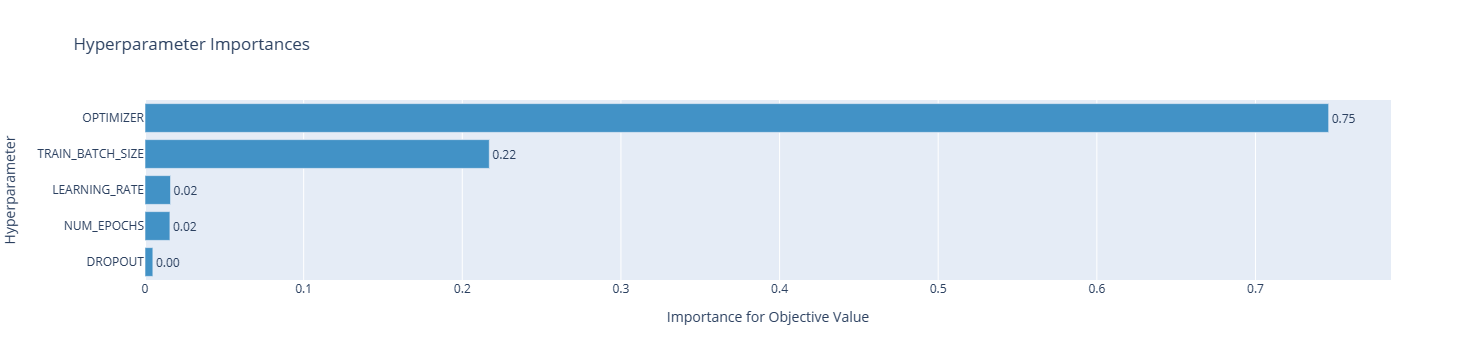

In [39]:
plot_param_importances(analysis_study)

Parallel coordinate plot displays the dependence of the objective value (recall scores) with respect to the hyper parameters. 
- The highest objective value corresponds to the droput value 0.5 and with 0.1 dropout we got lower recall scores. 
- Better learning rates lie below 0.009 and above 0.001.
- As for optimizer, SGD has provided the worst scores and ADAM gave the best scores.
- Objective value using batch size 32 ad 64 are reasonably similar but the training for **batch 32 is faster compartively to batch 64**. 

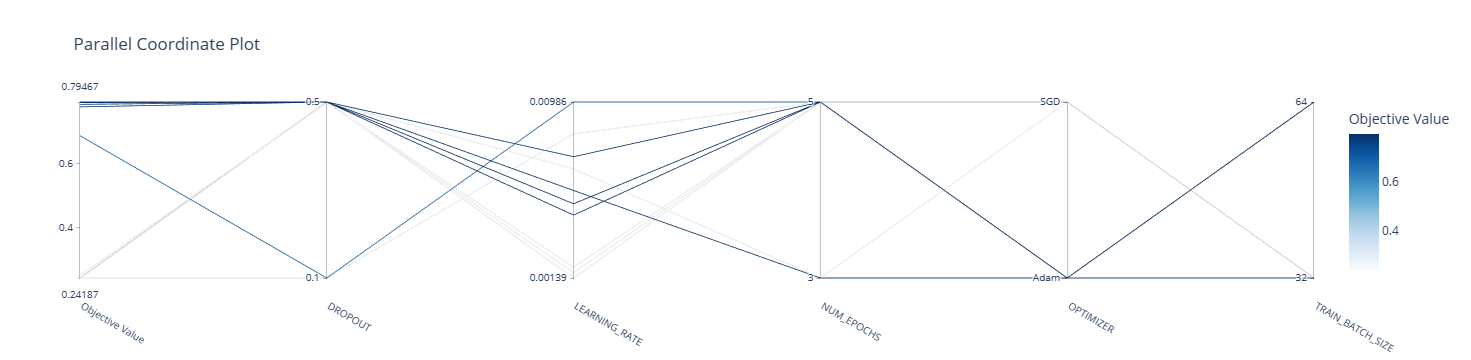

In [40]:
plot_parallel_coordinate(analysis_study)

> Below graph shows the history of the optimization trials that were conducted and this plot we can observe that trial 3 was able to achieve a higher recall (objective value), before that trial 0 and 2 were pretty close and they both had used ADAM with dropout 0.5 but with a higher learning rate and after that the next trials conducted using SGD gave worst results.

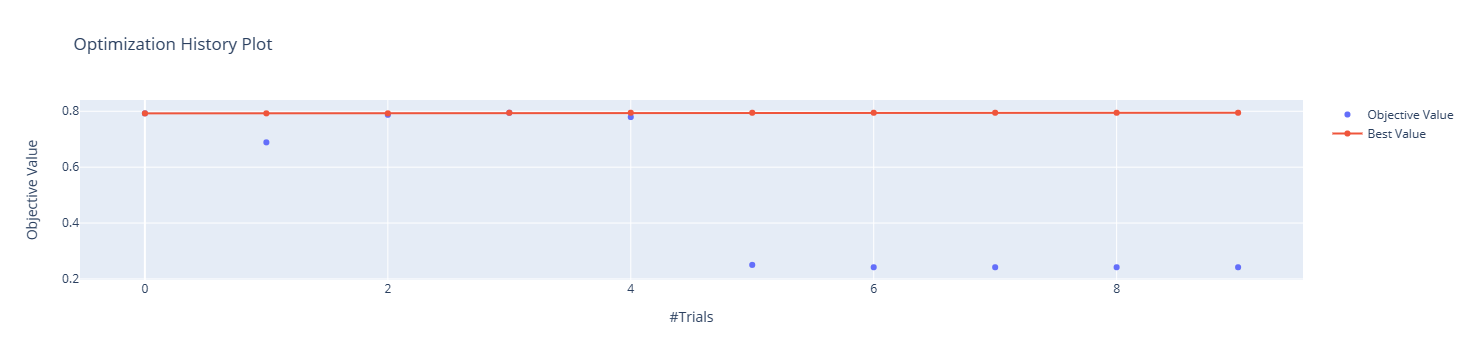

In [41]:
plot_optimization_history(analysis_study)

#### What were other design choices you faced?
> Objective was able to reach abouve 0.70 recall score with a simple 4 layered DNN model. However some regularisation techniques like dropout was included to have even better results.

## 2.d. Train your Model

In [62]:

set_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
training_params = {
        'TRAIN_BATCH_SIZE' : 64,
        'TEST_BATCH_SIZE' : 64,
        'LEARNING_RATE' : 0.001,
        'OPTIMIZER': optim.Adam,
        'NUM_EPOCHS' : 30
        'DROPOUT' : 0.5
}

model = MalwareNet(input_dim=train_data[0][0].shape[0], output_dim=len(label_encodings)).to(set_device)
print(f'Network structure is: {model.parameters}')
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')
    
criterion = nn.CrossEntropyLoss().to(set_device)
optimizer = training_params['OPTIMIZER'](model.parameters(), lr=training_params['LEARNING_RATE'])
with warnings.catch_warnings(record=True):
    train_loss_history, recall_train_history,  validation_loss_history, recall_validation_history = _network_training(model, training_params, criterion, optimizer, set_device, tuning=False)
        

Network structure is: <bound method Module.parameters of MalwareNet(
  (layers): Sequential(
    (0): Linear(in_features=5521, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
    (9): Dropout(p=0.1, inplace=False)
  )
)>
Total number of parameters: 6344842
Training =>  Epoch : 1 | Loss : 1.0109317820779113 | Recall score: 0.6532663316582915
Validation =>  Epoch : 1 | Loss : 0.6421010230862817 | Recall score: 0.7690902447935696 
Saving the model...
Training =>  Epoch : 2 | Loss : 0.7094655324553334 | Recall score: 0.7472818638647785
Validation =>  Epoch : 2 | Loss : 0.6110247948835063 | Recall score: 0.8019729630982828 
Saving the model...
Training =>  Epoch : 3 | Loss : 0.6534487901385441 | Recall

### Loss curves: Training Loss vs Validation Loss Per Epoch During Learning

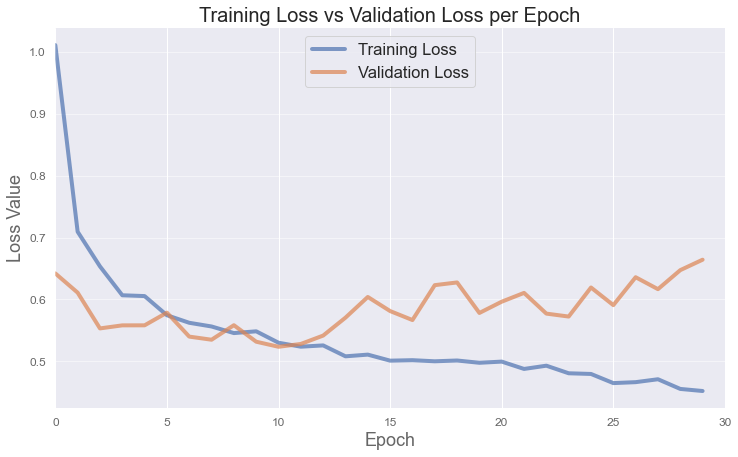

In [63]:

df = pd.DataFrame({'Training Loss':train_loss_history, 'Validation Loss':validation_loss_history})
df.plot(linewidth=4, alpha=0.7, figsize=(12,7), label='Loss')
plt.xlim([0,30])

plt.title('Training Loss vs Validation Loss per Epoch', fontsize=20)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Loss Value', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper center')
plt.show()


### Recall curves: Training Recall vs Validation Recall Per Epoch During Learning

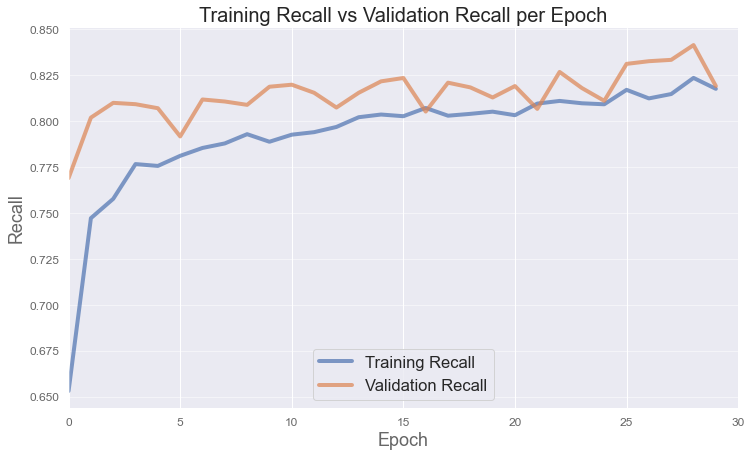

In [64]:

df = pd.DataFrame({'Training Recall':recall_train_history, 'Validation Recall':recall_validation_history})
df.plot(linewidth=4, alpha=0.7, figsize=(12,7), label='Loss')
plt.xlim([0,30])
# plt.ylim(-20,100)
plt.title('Training Recall vs Validation Recall per Epoch', fontsize=20)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Recall', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='lower center')
plt.show()


## 2.e. Evaluate model

In [77]:
def test_model(model, dataloader, vectorization_method, checkpoint_path=None):
    """
    Performs evaluation on the test set for a given model,
    while loading pretrained checkpoint from disk.
    """
    if checkpoint_path:
        load_model(model, checkpoint_path)  
    recall_test_history = list()

    model.eval()
    with torch.no_grad():
        y_true_test, y_pred_test= list(), list()

        for batch, targets, lengths in testloader:
            ## perform forward pass  
            batch = batch.type(torch.FloatTensor).to(set_device)
            pred = model(batch) 
            preds = torch.max(pred, 1)[1]

            ## accumulate predictions per batch for the epoch
            y_pred_test += list([list(label_encodings.keys())[x.item()] for x in preds.detach().cpu().numpy()])
            targets = torch.LongTensor([x.item() for x in list(targets)])
            y_true_test +=  list([list(label_encodings.keys())[x.item()] for x in targets.detach().cpu().numpy()])

        print(f"{vectorization_method} Vectorization: Test set")
        print(f'Recall score (Micro Avg)=> {evaluate_preds(y_true_test, y_pred_test)}')
        print(f'Classification Report =>\n {classification_report(y_true_test, y_pred_test)}')

In [78]:
## evaluate model on test set
set_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with warnings.catch_warnings(record=True):
    testloader = DataLoader(malware_testset, batch_size=32, shuffle=False)  
    model = MalwareNet(input_dim=train_data[0][0].shape[0], output_dim=len(label_encodings)).to(set_device)
    test_model(model, testloader, vectorization_method, f'{vectorization_method}_model.ckpt')

BOW Vectorization: Test set
Recall score (Micro Avg)=> 0.8408
Classification Report =>
               precision    recall  f1-score   support

       Agent       0.70      0.50      0.58       294
     Allaple       0.99      1.00      1.00       345
      AutoIt       0.99      1.00      1.00       467
       Basun       0.82      0.94      0.88      1563
NothingFound       0.80      0.74      0.77      2528
     Patched       0.33      0.02      0.03       335
     Swizzor       0.98      1.00      0.99       428
       Texel       0.80      0.94      0.86      2585
          VB       0.91      0.87      0.89       556
       Virut       0.93      0.84      0.89       899

    accuracy                           0.84     10000
   macro avg       0.83      0.78      0.79     10000
weighted avg       0.83      0.84      0.83     10000



## 2.f. Save Model + Data

In [30]:
## saving the model
save_model(model, out_path=f"{vectorization_method}_model.ckpt")

## saving the train dataset
pickle_file(f"train_v{MAX_VOCAB_SIZE}_{vectorization_method}.pkl", train_data)

## saving the test dataset
pickle_file(f"test_v{MAX_VOCAB_SIZE}_{vectorization_method}.pkl", test_data)

# 3. Analysis

## 3.a. Summary: Main Results

**Vectorization Approach:** For vectorization we considered three approaches which include **Bag-Of-Words** which places '1' if a certain token from dictionary occurs in the given document then it adds '1' at the index of that token for that given document, hence resulting in a matrix equivalent to (number of documents x vocabulary size), secondly, we opted for **Count Vectorizer** which similar to Bag-Of-Words however instead of placing '1' it places the count of that perticular term in the given document at the index. Finally, we chose **TF-IDF (term frequency–inverse document frequency)** which more sphosticated as it computes term importance by computing term frequencies and inverse document frequencies in order to give weight to rare terms which could be important for a given document during training of a classifier. After computing the vectors using the above mentioned approaches we then trained separate malware classifiers for each vectorized dataset, and performed hyperparameter tuning for each. Also, we chose **recall** also known as true positive rate as **evaluation metric**, since we it computes the rate of correctly predicted malwares out of the true class of malware, since our goal is to correctly identify the category of malware since that would greatly help in the consequent diagnostic measures.

Following are the results for the best models from each vectorizer.

In [92]:
## Print recall score and classification reports of all three vectorization methods
vectorization_methods = ["BOW", "COUNT_VEC", "TF_IDF"]

for vec_method in vectorization_methods:
    ## read test data from disk
    test_data = unpickle_file(f'test_v{MAX_VOCAB_SIZE}_{vec_method}.pkl')
    
    ## wrap it with torch data set
    malware_testset = MalwareDataset(test_data[0], test_data[1], test_data[2])
    
    ## create dataloader from the dataset
    testloader = DataLoader(malware_testset, batch_size=32, shuffle=False)  
    
    ## init empty model
    model = MalwareNet(input_dim=test_data[0][0].shape[0], output_dim=len(label_encodings)).to(set_device)
    
    ## perform evaluation by providing path to checkpoint
    test_model(model, testloader, vec_method, f'{vec_method}_model.ckpt')

BOW Vectorization: Test set
Recall score (Micro Avg)=> 0.8388
Classification Report =>
               precision    recall  f1-score   support

       Agent       0.62      0.57      0.60       294
     Allaple       1.00      1.00      1.00       345
      AutoIt       0.99      1.00      1.00       467
       Basun       0.82      0.94      0.88      1563
NothingFound       0.81      0.71      0.76      2528
     Patched       0.60      0.01      0.02       335
     Swizzor       0.98      1.00      0.99       428
       Texel       0.79      0.96      0.86      2585
          VB       0.90      0.87      0.88       556
       Virut       0.95      0.84      0.89       899

    accuracy                           0.84     10000
   macro avg       0.85      0.79      0.79     10000
weighted avg       0.83      0.84      0.82     10000

COUNT_VEC Vectorization: Test set
Recall score (Micro Avg)=> 0.7735
Classification Report =>
               precision    recall  f1-score   support

    

## 3.b. Discussion

Enter your final summary here.

For instance, you can address:
- **What was the performance you obtained with the simplest approach?** <br/>
We achieved the recall score of 84% (micro averaged) with the simplest approach Bag-Of-Words which computes sparse vectors each documents by placing '1' for each occurence of a term in the given document.

- **Which vectorized input representations helped more than the others?** <br/>
The simplest Bag-of-words approach outperformed the other counter vectorizer and tf-idf vectorizer. Also, following is the plot of per batch recall scores (micro averaged) of each of the vectorizer's best model on the test set. It can be seen that BOW approach makes more stable and quality predictions as compared to the other two across all batches of test set.
![Malware Per Batch Test Recall](https://raw.githubusercontent.com/shahrukhx01/ocr-test/main/per_batch_recall_malware.png)

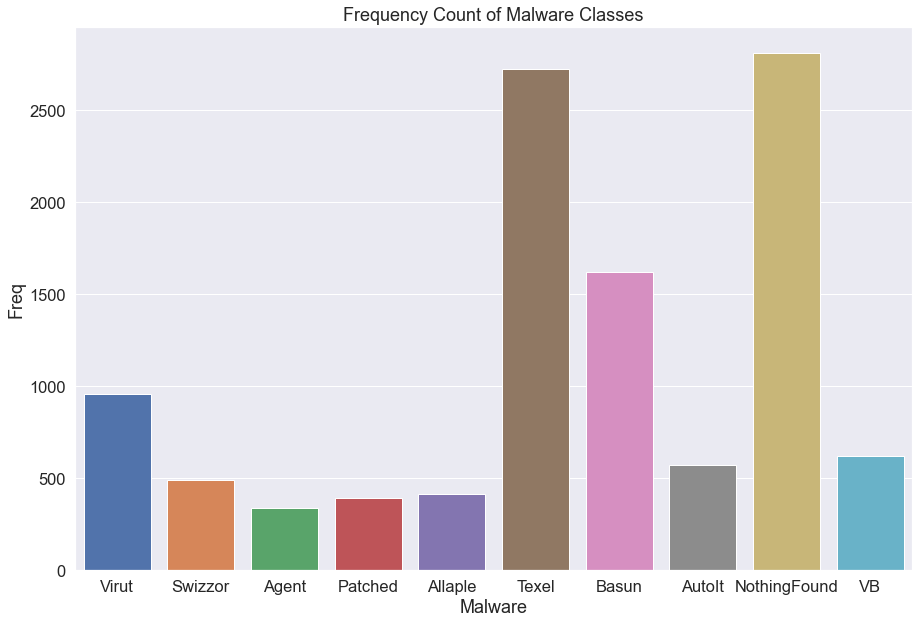

In [43]:
dff = pd.DataFrame()
dff['Freq'] = pd.Series(train_data[1]).value_counts().sort_index()
dff['Malware'] = ['Virut', 'Swizzor', 'Agent', 'Patched',  'Allaple', 'Texel',  'Basun',  'AutoIt',  'NothingFound', 'VB']
sns.set(rc={"figure.figsize":(15, 10)}, font_scale = 1.5)
ax = sns.barplot(x="Malware", y="Freq", data=dff, saturation=.9).set(title='Frequency Count of Malware Classes')

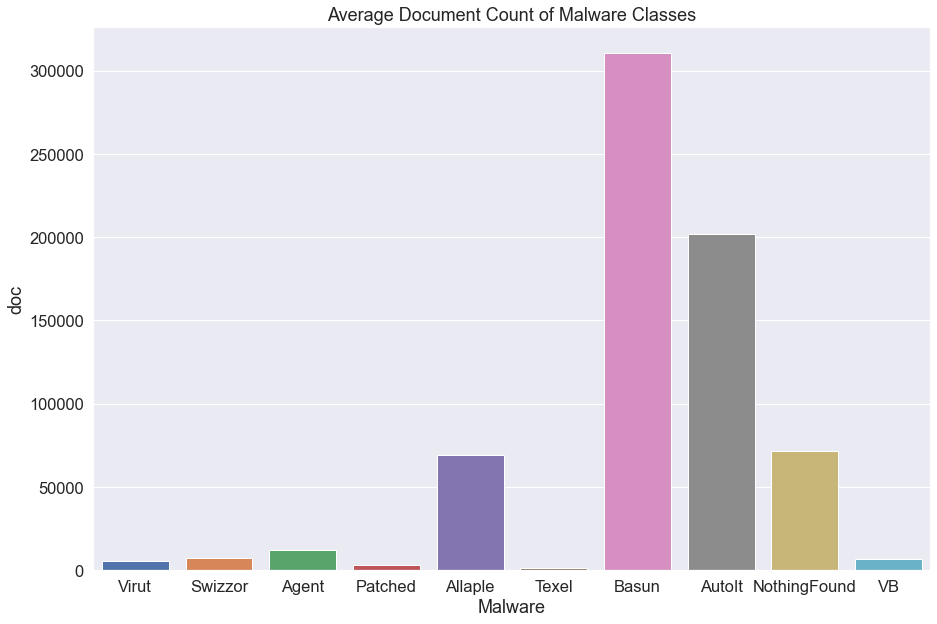

In [44]:
dd = pd.DataFrame([pd.Series(train_data[1]), pd.Series(train_data[2])]).T
dd.columns = ['malware_class', 'doc']
dd = dd.groupby(by='malware_class').mean()
dd['Malware']= ['Virut', 'Swizzor', 'Agent', 'Patched',  'Allaple', 'Texel',  'Basun',  'AutoIt',  'NothingFound', 'VB']
sns.set(rc={"figure.figsize":(15, 10)}, font_scale = 1.5)
ax = sns.barplot(x="Malware", y="doc", data=dd, saturation=.9).set(title='Average Document Count of Malware Classes')

- **Which malwares are difficult to detect and why?** <br/>
Malware **'Patched'** proved to be the most difficult to detect the best model producing a recall score of mere 1% whereas the other two approaches yielded 0% recall. Secondly, malware **'Agent'** was also slightly tricky to detect for all the model which yielded the accuracy of 57% by the best model. 
<br/>This could be down to the following reasons: <br/>
Firstly, **class imbalance** it can be seen in the following plot of labels distribution in terms of frequency in the training dataset. It is clearly evident both malwares Agent and Patched have less than 1/5 of the number of training samples as compared to the most frequent malware 'Texel', this could've prevented the classifier to not find any reasonable patterns since the number of samples were too small for these two malwares.

![Malware Labels Histogram](https://raw.githubusercontent.com/shahrukhx01/ocr-test/main/freq_malware.png)

Secondly, another potential reason could be **small document content length** it can be seen below where we present the average document length for each type of malware in training dataset. Also, both these malwares have small average content length, however, the smallest content length based malware **texel** still manages to achieve a recall score of 91% on the best model. So, potentially either one of these two reasons or both have contributed to make them very hard to detect.
![Malware Document Length](https://raw.githubusercontent.com/shahrukhx01/ocr-test/main/document_len_malware.png)

- **Which approach do you recommend to perform malware classification?** <br/>
Empirically, BOW (Bag-Of-Words) outperformed the other two vectorization approaches, however, more sphosticated vectorizers which incorporate contextual information from the sequences such as word embeddings (Word2Vec) and recent state-of-the-art attention mechanism based transformer model based approaches such as BERT, GPT-2/3 can potentially produce far better quality of results when detecting the type of malware. However, the downside would such approaches are more effective on sequences of smaller to medium length sequnces (512 to 2k tokens per document/sequence), however, in our case some of the malware files was 300k token per document/sequence. However, incorporating some contextual information could prove to be interesting.